<a href="https://colab.research.google.com/github/garghimank09/Loan-Default-Prediction/blob/main/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import shap

# To scale the data using Standard Scaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

import scipy.stats as stats

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
hm = pd.read_csv('/content/hmeq.csv')

In [ ]:
data = hm.copy()

In [ ]:
data.head()


In [ ]:
data.tail()


In [ ]:
data.shape


Observations:

The dataset has 5960 rows and 13 columns.

In [ ]:
data.info()

Observations:

REASON & JOB are of object type and the rest of the columns are numeric type .

In [ ]:
(data.isnull().sum())

Observations:

11 columns have null values.
BAD and LOAN columns have no null values.

In [ ]:
(data.isnull().sum()/data.shape[0] * 100)

Observations:

5 columns (Value, Reason, Job, Clage, CLNO) have around 1% - 5% of missing values.
4 columns (Mortdue, Yoj, Delinq, Ninq) have around 10% of missing values.
1 column (Debtinc) has more than 20% of missing values.
In total, 11 of 13 columns have missing values.

Convert the data type

In [ ]:
cols = data.select_dtypes(['object']).columns.tolist()

#adding target variable to this list as this is a classification problem and the target variable is categorical

cols.append('BAD')

In [ ]:
cols


In [ ]:
# Changing the data type of object type column to category.

for i in cols:
    data[i] = data[i].astype("category")

In [ ]:
data.info()

Summary Statistic

In [ ]:
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
data[num_cols].describe().T

Insights-

LOAN: The "LOAN" column represents the loan amount requested by the client. The mean loan amount is approximately 18,608 with a wide range of values. The highest loan amount is approximately 89,900.

MORTDUE: The "MORTDUE" column represents the amount of the existing mortgage due for the property. There are missing values in this column. The mean mortgage due is approximately 73,761.

VALUE: The "VALUE" column represents the value of the property. The mean property value is approximately 101,776, with a wide range of values. The highest property value is 855,909.

YOJ: The "YOJ" column represents the number of years in the job for the client. The mean years in the job is approximately 8.92 years.

DEROG: The "DEROG" column represents the number of major derogatory reports on the client's credit history. The mean number of derogatory reports is approximately 0.25.

DELINQ: The "DELINQ" column represents the number of delinquent credit lines on the client's credit history. The mean number of delinquent credit lines is approximately 0.45.

CLAGE: The "CLAGE" column represents the age of the oldest trade line in months. The mean age of the oldest trade line is approximately 179.77 months.

NINQ: The "NINQ" column represents the number of recent credit lines on the client's credit history. The mean number of recent credit lines is approximately 1.19.

CLNO: The "CLNO" column represents the number of credit lines on the client's credit history. The mean number of credit lines is approximately 21.30.

DEBTINC: The "DEBTINC" column represents the debt-to-income ratio for the client. The mean debt-to-income ratio is approximately 33.78.

In [110]:

data.describe(include=['category']).T

,count,unique,top,freq
BAD,5960,2,0,4771
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


Insights-

BAD: The "BAD" column represents whether a client defaulted (value is 1) or did not defaulted (value 0) and has a frequency of 80%. This means the other 20% of clients have defaulted at least once.

REASON: The "REASON" column represents the reason for the loan, with two unique values: "DebtCon" (Debt Consolidation) and "HomeImp" (Home Improvement). The most common reason for the loan is debt consolidation (DebtCon).

JOB: The "JOB" column represents the job type of the client. There are six unique job types, with "Other" being the most common job type.

In [ ]:
cols_cat= data.select_dtypes(['category'])

for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(data[i].value_counts(normalize = True))
    print('*'*40)

Insights-

80% of client are non defaulted. 20% of them are defaulted.
Around 69% ask for loans to pay other liabilities and consumer debts. ~30% ask for loans to make home improvements.
There are six types of jobs: ~58% of those jobs are proffesional executives, Office employees, Managers, self employed, sales. The 42% is in Other job.

The percentage of defaulters in the data is BAD
0    80.050336
1    19.949664
Name: count, dtype: float64 %


[]

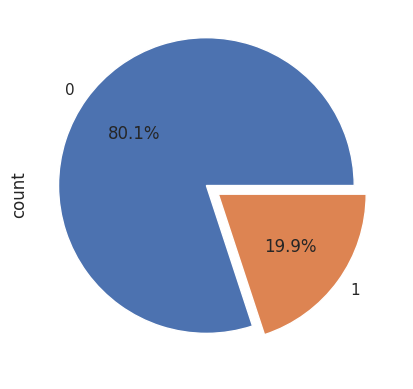

In [112]:
perc_default = data['BAD'].value_counts() / len(data['BAD'])
print(f'The percentage of defaulters in the data is {perc_default*100} %')
data['BAD'].value_counts().plot(kind='pie',explode=[0.1,0],autopct="%1.1f%%")
plt.plot()

Observations:

20% of the clients in the dataset are defaulter on their loans (BAD=1).
80% of the clients have successfully repaid their loans or are not defaulter (BAD=0).

In [ ]:
def show_value_counts(col):
    print(col)
    value_counts = data[col].value_counts()
    percentage = value_counts / len(data) * 100
    result_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts, 'Percentage': percentage})
    result_df = result_df.sort_values(by='Value')
    print(result_df)
    print('--------------------------')
    generate_pie_plot(result_df)


def generate_pie_plot(data_frame):
    plt.figure(figsize=(6, 5))
    plt.pie(data_frame['Count'], labels=data_frame['Value'], autopct='%1.1f%%')
    plt.axis('equal')
    plt.show()


REASON
           Value  Count  Percentage
REASON                             
DebtCon  DebtCon   3928   65.906040
HomeImp  HomeImp   1780   29.865772
--------------------------


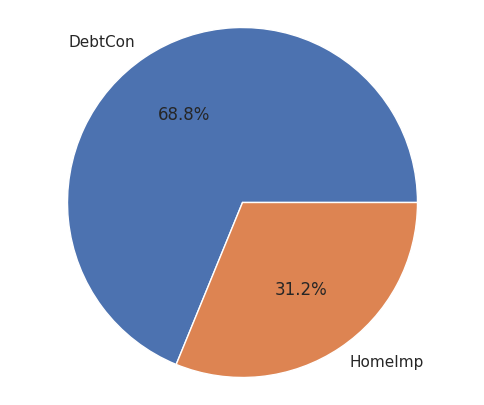

In [114]:
show_value_counts('REASON')

Observations:

Majority of clients (around 69.8%) have taken out loans for debt consolidation (DebtCon), indicating a higher frequency.

Smaller portion of clients (around 30.2%) have taken out loans for home improvement purposes (HomeImp).

JOB
           Value  Count  Percentage
JOB                                
Mgr          Mgr    767   12.869128
Office    Office    948   15.906040
Other      Other   2388   40.067114
ProfExe  ProfExe   1276   21.409396
Sales      Sales    109    1.828859
Self        Self    193    3.238255
--------------------------


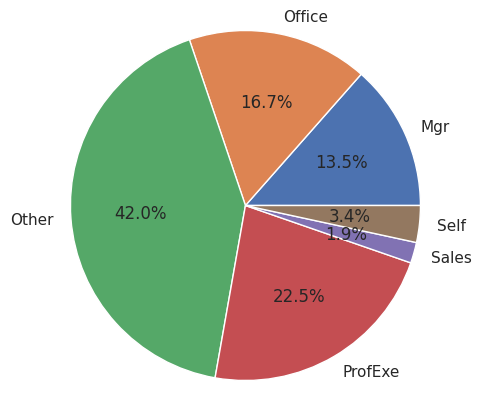

In [115]:
show_value_counts('JOB')

Observations:

Maximum number of clients mentioned their job category is "Other" (around 44.7%). This category likely includes diverse job roles not covered by the specific categories.
"ProfExe" (Professional/Executive) most common job category, approximately 21.4% of the clients.
"Office" job category around 15.8% of clients.
"Mgr" (Manager), "Self" (Self-Employed), and "Sales" job categories have relatively smaller representations, with approximately 12.9%, 3.2%, and 1.8% of clients, respectively.

LOAN
Skew : 2.02


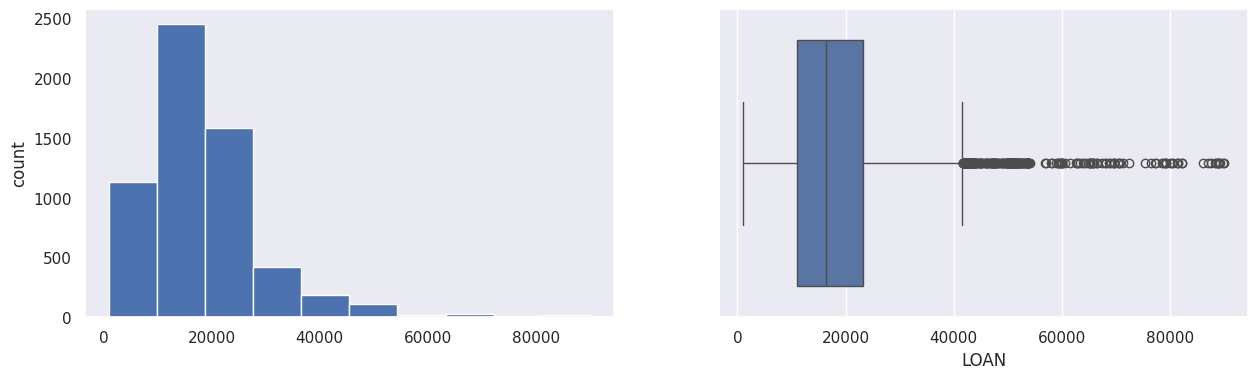

MORTDUE
Skew : 1.81


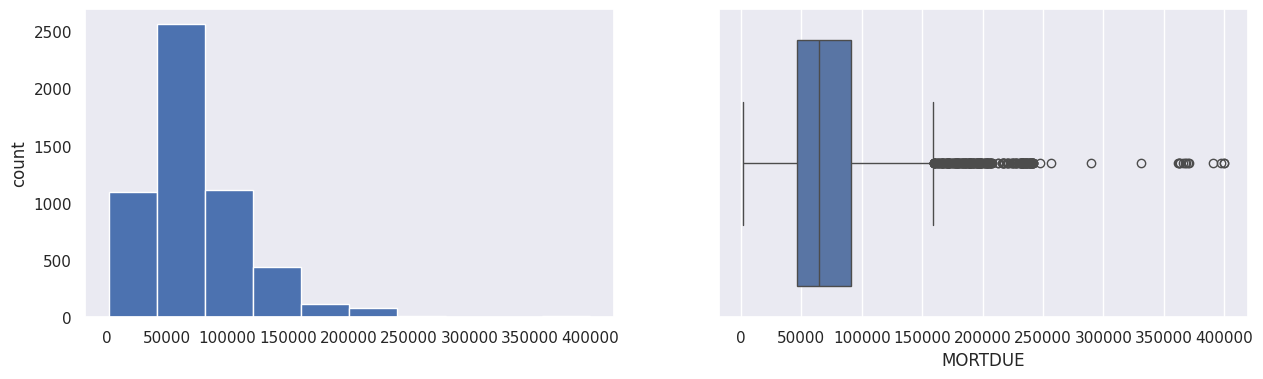

VALUE
Skew : 3.05


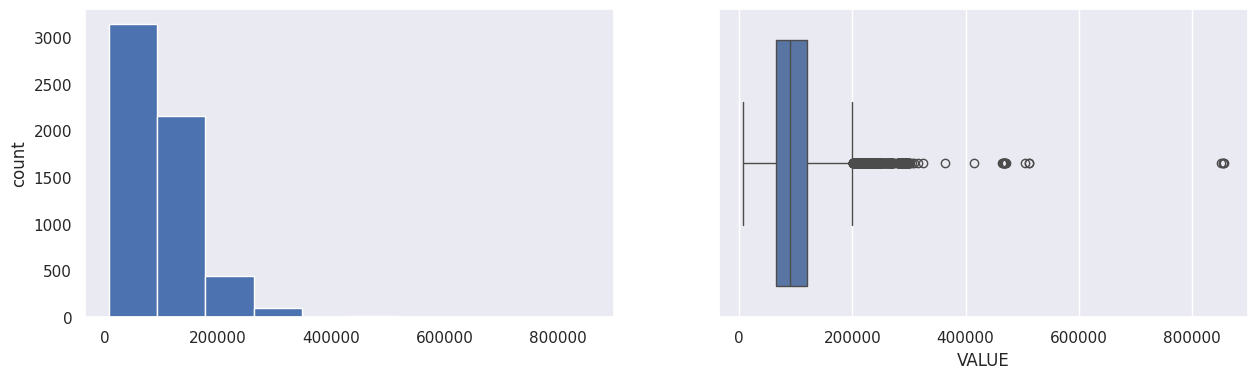

YOJ
Skew : 0.99


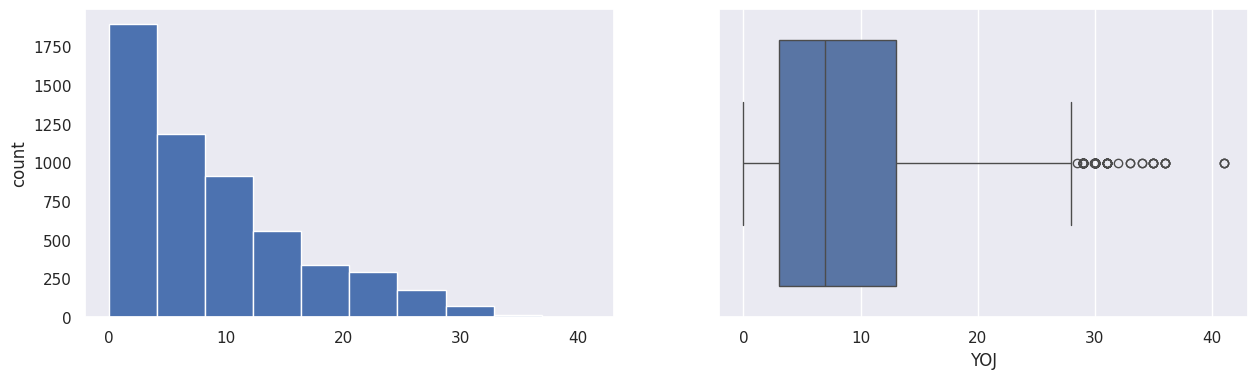

DEROG
Skew : 5.32


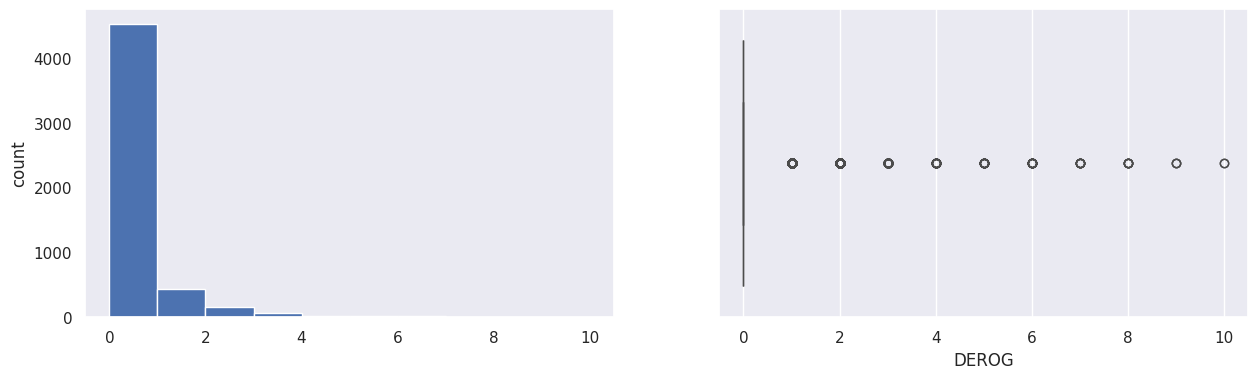

DELINQ
Skew : 4.02


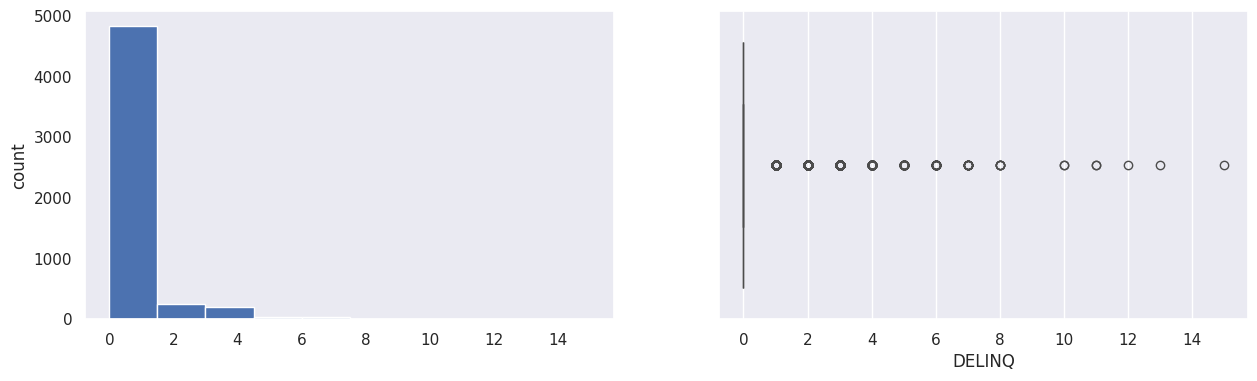

CLAGE
Skew : 1.34


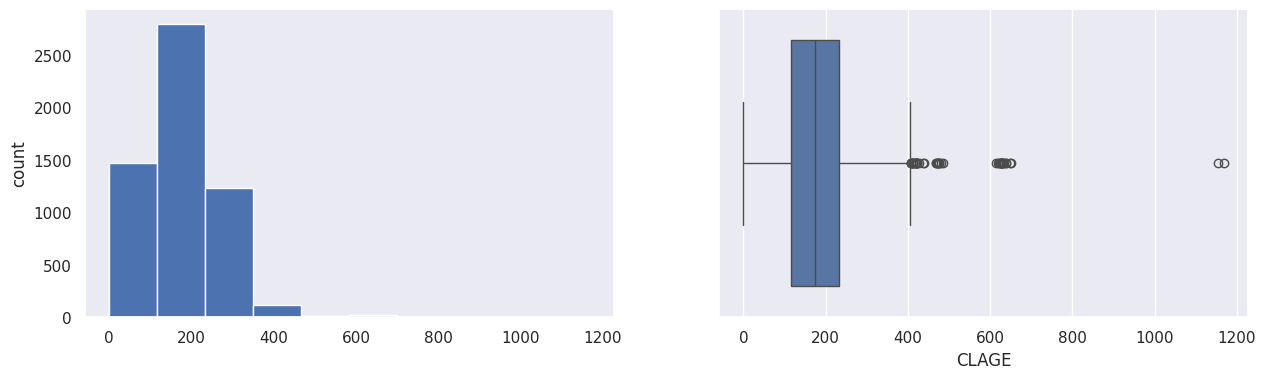

NINQ
Skew : 2.62


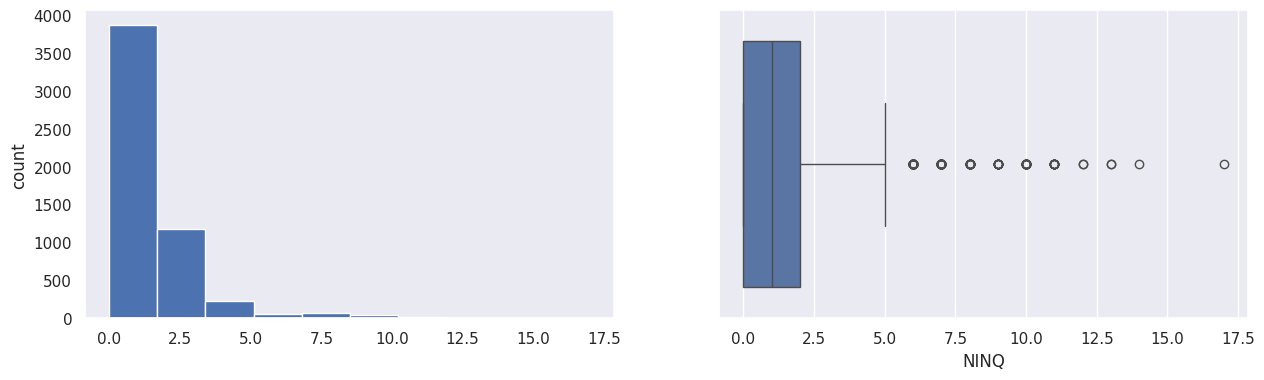

CLNO
Skew : 0.78


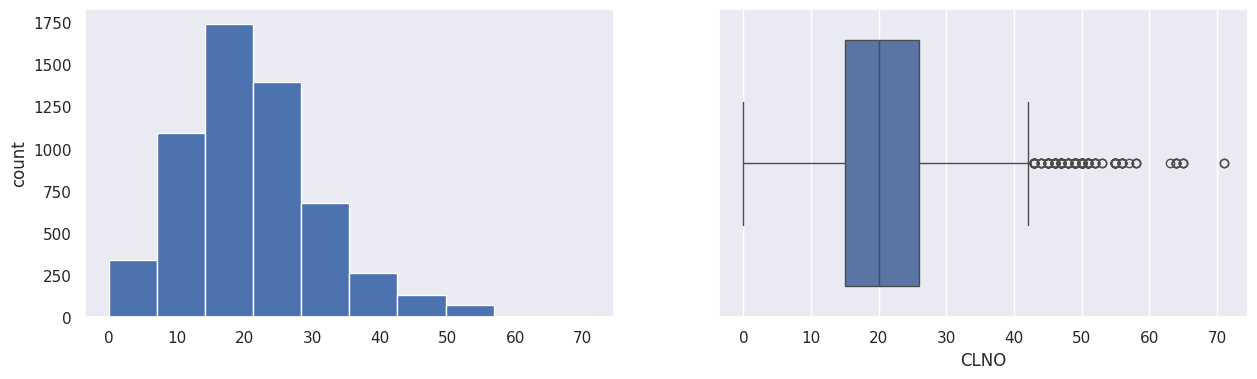

DEBTINC
Skew : 2.85


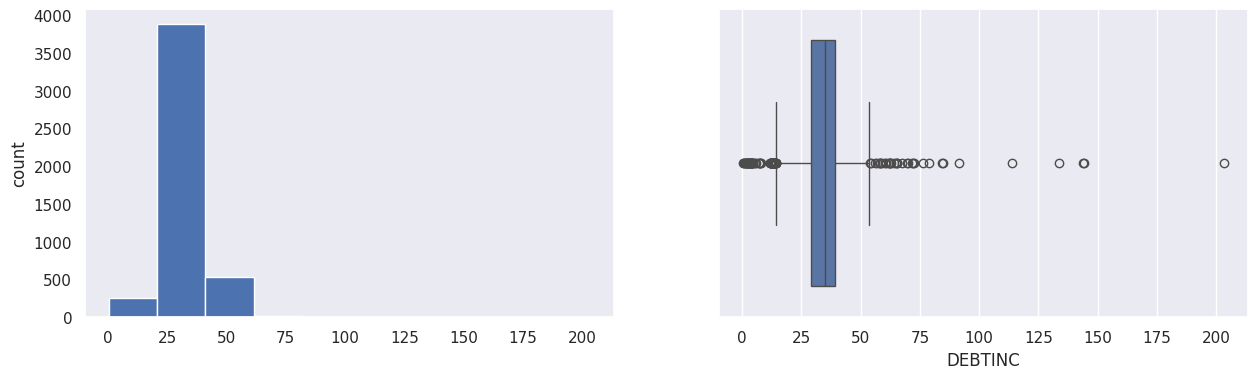

In [116]:
for feature in num_cols:
    print(feature)

    print('Skew :',round(data[feature].skew(), 2))

    plt.figure(figsize = (15, 4))

    plt.subplot(1, 2, 1)

    data[feature].hist(bins = 10, grid = False)

    plt.ylabel('count')

    plt.subplot(1, 2, 2)

    sns.boxplot(x = data[feature])

    plt.show()

Observations:

LOAN, MORTDUE, VALUE, CLNO, DEBTINC variables have outliers.
DEBTINC normal shape distribution that shows outliers on the right and left ends.
The variable LOAN has a skewed distribution to the right with lot of big outliers compared to the mean.
The variable YOG is very skewed to the right and has a few outliers.

<Axes: xlabel='BAD', ylabel='LOAN'>

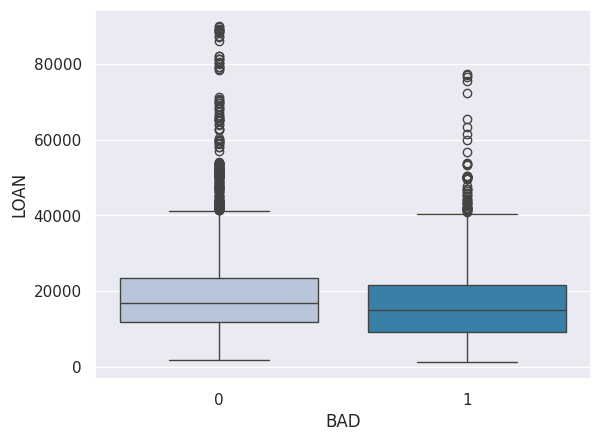

In [117]:
sns.boxplot(x=data["BAD"],y=data['LOAN'],palette="PuBu")

Insight: it seems that bothe type of client (defaulted or not) receive the same amount of loans

<Axes: xlabel='BAD', ylabel='MORTDUE'>

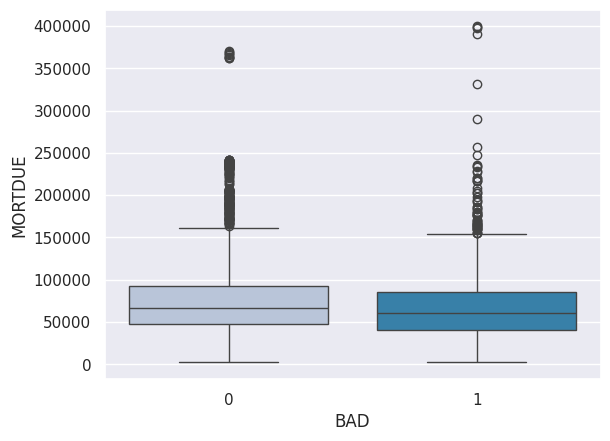

In [118]:
sns.boxplot(x=data["BAD"],y=data['MORTDUE'],palette="PuBu")

insights:

Both type of client (defaulted or not) have the same amount due on the existing mortgage.

<Axes: xlabel='VALUE', ylabel='MORTDUE'>

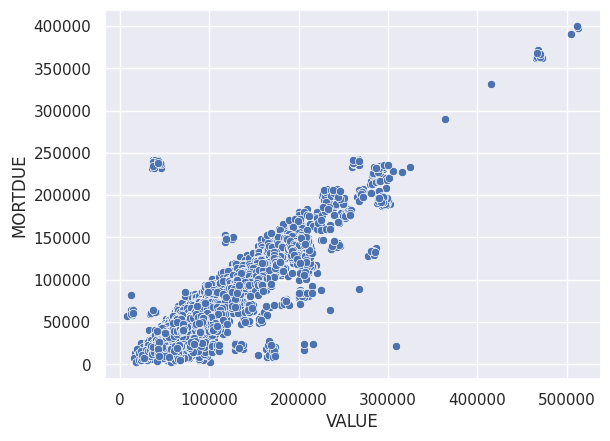

In [119]:
#scatterplot VALUE vs MORTDUE
sns.scatterplot(x=data["VALUE"],y=data['MORTDUE'],palette="PuBu")

Insights:

There is a linear correlation between the variables VALUE and MORTDUE.

<Axes: xlabel='LOAN', ylabel='VALUE'>

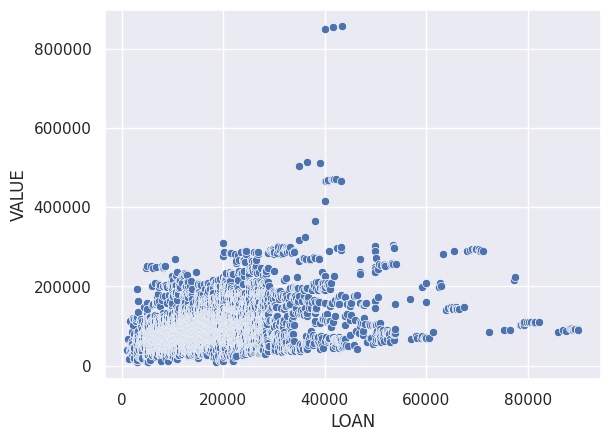

In [120]:

sns.scatterplot(x=data["LOAN"],y=data['VALUE'],palette="PuBu")

Insights:

There is a no correlation between the value of the property and the loan default rate.

In [121]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=0)
    plt.show()

BAD         0     1   All
REASON                   
All      4567  1141  5708
DebtCon  3183   745  3928
HomeImp  1384   396  1780
------------------------------------------------------------------------------------------------------------------------


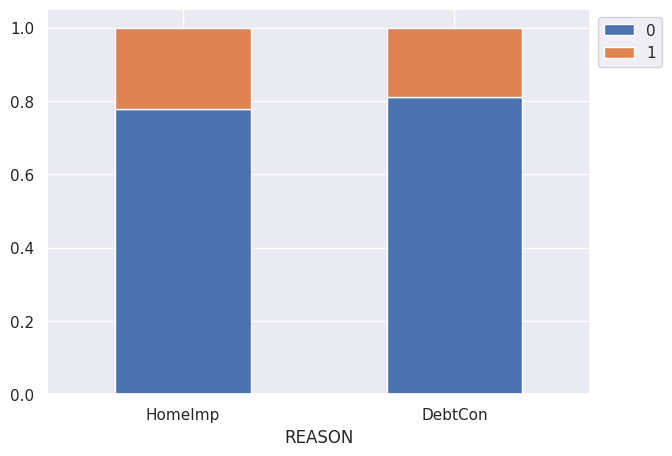

In [122]:
stacked_barplot(data, "REASON", "BAD")

Observation:

Both reason debt consolidation or home improvement have no such difference on loan defaulter or not

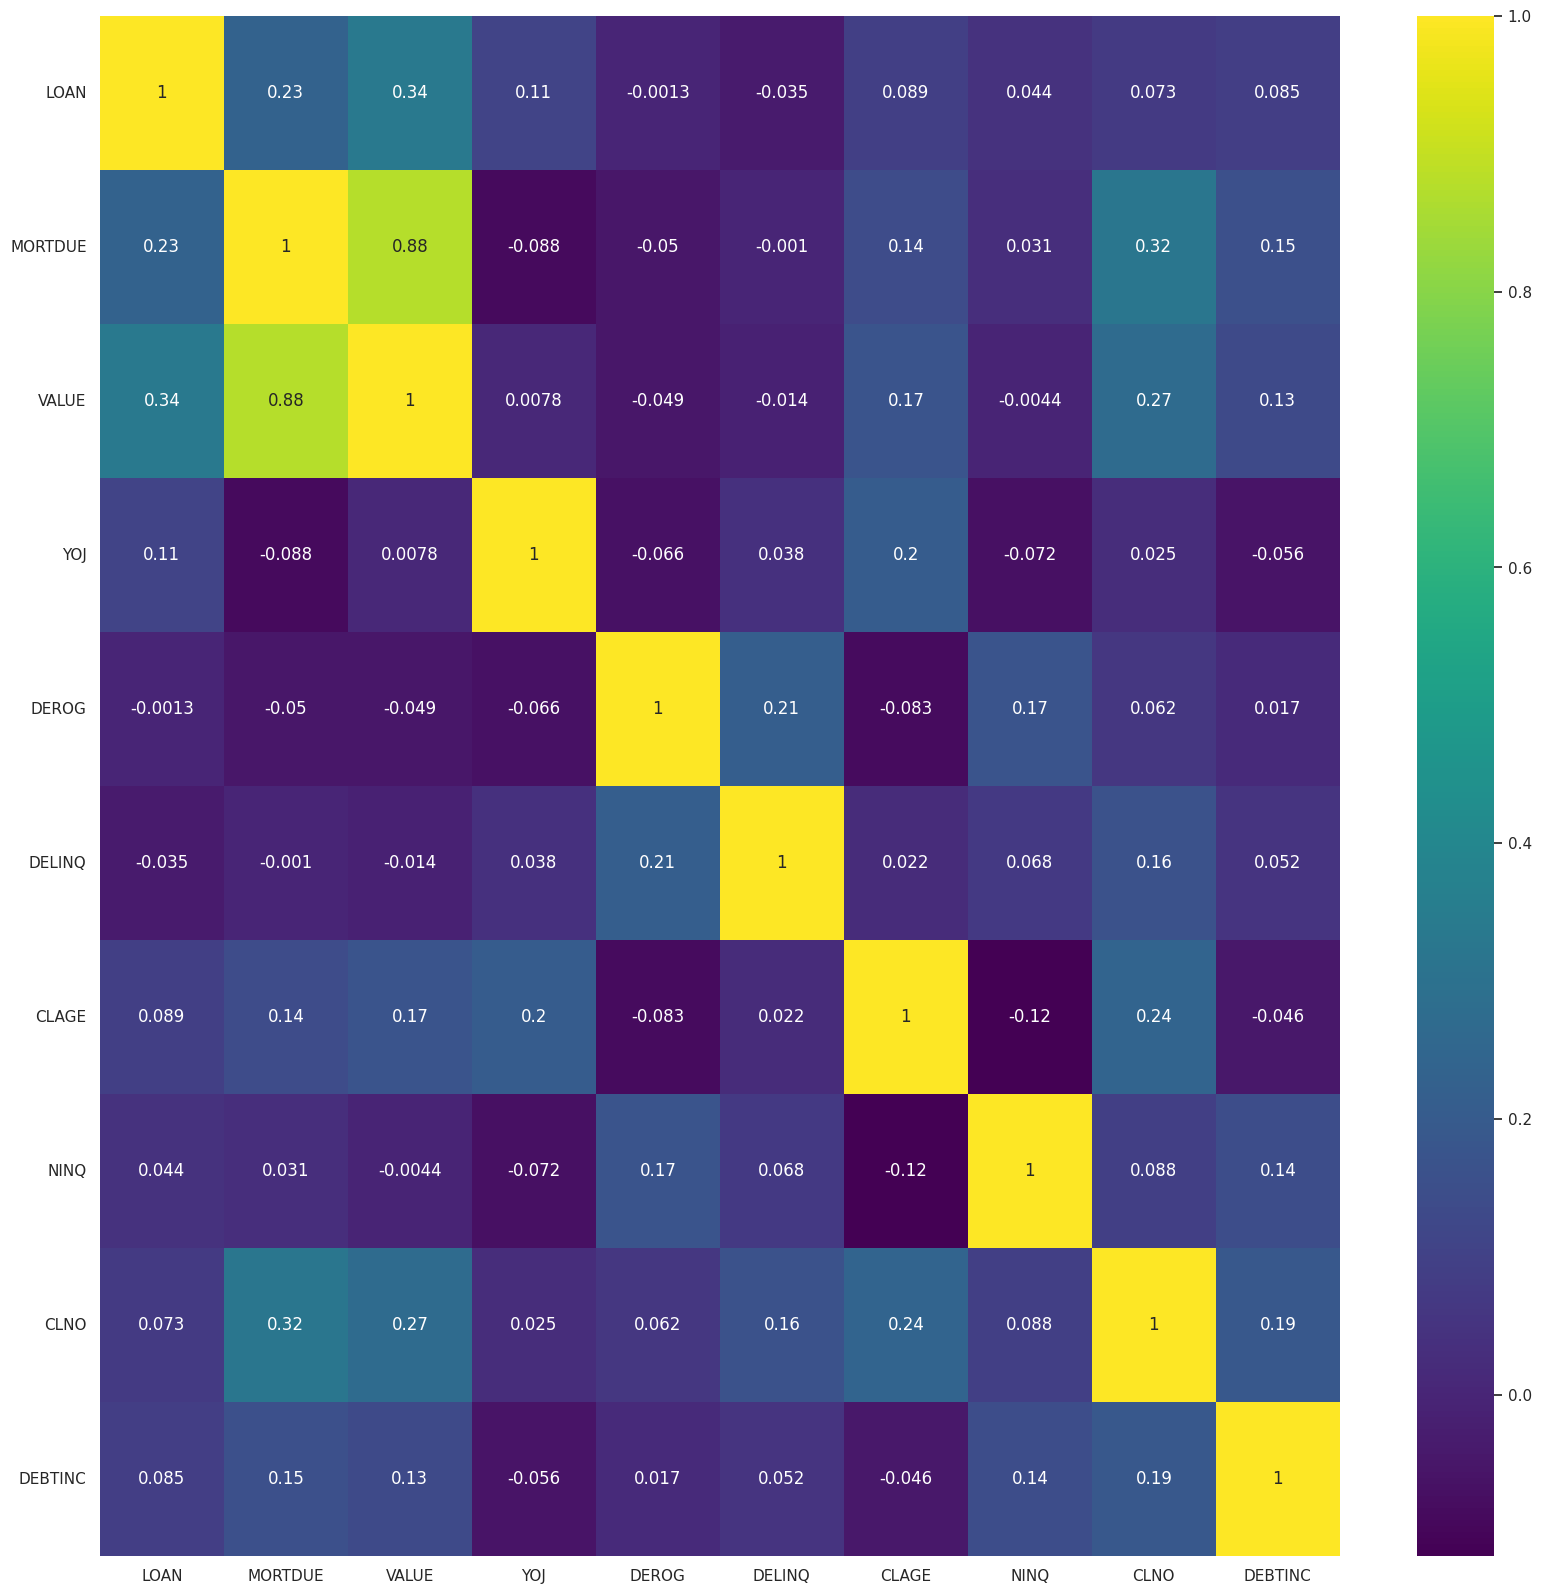

In [123]:
plt.figure(figsize=(20, 20))
heat_map = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="viridis")
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

In [124]:
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame

    '''

    Q1=df[col].quantile(q = .25) # 25th quantile
    Q3=df[col].quantile(q = .75)  # 75th quantile
    IQR = Q3-Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)

    return df

In [125]:
#copy data
df_raw = data.copy()

numerical_col = df_raw.select_dtypes(include=np.number).columns.tolist()# getting list of numerical columns

df = treat_outliers_all(df_raw,numerical_col)

In [126]:
df


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,41600,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,41600,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,41600,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,41600,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Adding new columns in the dataset for each column which has missing values

In [127]:
def add_binary_flag(df,col):
    '''
    df: It is the dataframe
    col: it is column which has missing values
    It returns a dataframe which has binary falg for missing values in column col
    '''
    new_col = str(col)
    new_col += '_missing_values_flag'
    df[new_col] = df[col].isna().astype(int)
    return df

In [128]:
missing_col = [col for col in df.columns if df[col].isnull().any()]

for colmn in missing_col:
    add_binary_flag(df,colmn)

Filling missing values in numerical columns with median and mode in categorical variables

In [129]:
num_data = df.select_dtypes('number')


cat_data = df.select_dtypes('category').columns.tolist() #df.select_dtypes('object')


df[num_data.columns] = num_data.fillna(num_data.median())

# Filling object columns with mode.
for column in cat_data:
    mode = df[column].mode()[0]
    df[column].fillna(df[column].mode()[0], inplace=True)

In [130]:
df.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,0
VALUE,0
REASON,0
JOB,0
YOJ,0
DEROG,0
DELINQ,0
CLAGE,0


In [131]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,0,0,0,0,0,0,0,0,0,1
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,...,0,0,0,0,0,0,0,0,0,1
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,0,0,0,0,0,0,0,0,0,1
3,1,1500,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,...,1,1,1,1,1,1,1,1,1,1
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,0,0,0,0,0,0,0,0,0,1


In [132]:
df.tail()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
5955,0,41600,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,...,0,0,0,0,0,0,0,0,0,0
5956,0,41600,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,...,0,0,0,0,0,0,0,0,0,0
5957,0,41600,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,...,0,0,0,0,0,0,0,0,0,0
5958,0,41600,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,...,0,0,0,0,0,0,0,0,0,0
5959,0,41600,48811.0,88934.0,DebtCon,Other,15.0,0.0,0.0,219.601002,...,0,0,0,0,0,0,0,0,0,0


In [133]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5960 non-null   category
 1   LOAN                         5960 non-null   int64   
 2   MORTDUE                      5960 non-null   float64 
 3   VALUE                        5960 non-null   float64 
 4   REASON                       5960 non-null   category
 5   JOB                          5960 non-null   category
 6   YOJ                          5960 non-null   float64 
 7   DEROG                        5960 non-null   float64 
 8   DELINQ                       5960 non-null   float64 
 9   CLAGE                        5960 non-null   float64 
 10  NINQ                         5960 non-null   float64 
 11  CLNO                         5960 non-null   float64 
 12  DEBTINC                      5960 non-null   float64 
 13  MOR

Droping missing value flags

In [134]:
bool_cols = df.select_dtypes(['bool']).columns.tolist()

#droping missing value flags
X = df.drop(columns = bool_cols)

In [135]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5960 non-null   category
 1   LOAN                         5960 non-null   int64   
 2   MORTDUE                      5960 non-null   float64 
 3   VALUE                        5960 non-null   float64 
 4   REASON                       5960 non-null   category
 5   JOB                          5960 non-null   category
 6   YOJ                          5960 non-null   float64 
 7   DEROG                        5960 non-null   float64 
 8   DELINQ                       5960 non-null   float64 
 9   CLAGE                        5960 non-null   float64 
 10  NINQ                         5960 non-null   float64 
 11  CLNO                         5960 non-null   float64 
 12  DEBTINC                      5960 non-null   float64 
 13  MOR

In [136]:
Y = X.BAD
X = X.drop(columns = ['BAD'])

to_get_dummies_for = ['REASON', 'JOB']

# Creating dummy variables
X = pd.get_dummies(data = X, columns = to_get_dummies_for, drop_first = True)

Scaling the data:
In this case features have different scales, so we will use the Standard Scaler method, which centers and scales the dataset using the Z-Score

In [137]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [138]:
X_scaled


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.832283,-1.268083,-1.328686,0.251171,0.0,0.0,-1.071599,-0.065054,-1.297476,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
1,-1.810666,-0.026523,-0.670929,-0.240303,0.0,0.0,-0.721212,-0.826792,-0.756608,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
2,-1.789048,-1.615326,-1.828581,-0.661566,0.0,0.0,-0.368698,-0.065054,-1.189302,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
3,-1.789048,-0.167948,-0.204386,-0.240303,0.0,0.0,-0.062534,-0.065054,-0.107566,0.140949,...,4.283766,3.268987,5.083979,1.924584,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
4,-1.767431,0.753003,0.305350,-0.801987,0.0,0.0,-1.084781,-0.826792,-0.756608,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,2.299330,-0.899944,-0.521936,-0.136489,-0.182938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,2.545249,-0.385818,-0.183125,1.023488,0.0,0.0,0.554157,-0.826792,-0.540260,0.344808,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5956,2.545249,-0.461334,-0.121503,1.023488,0.0,0.0,0.386830,-0.826792,-0.648434,0.305051,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5957,2.545249,-0.476252,-0.121794,0.883067,0.0,0.0,0.432597,-0.826792,-0.648434,0.257259,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5958,2.545249,-0.579498,-0.145596,0.742645,0.0,0.0,0.453174,-0.826792,-0.540260,0.065746,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938


Splitting the data into 70% train and 30% test set

The data is unbalanced (~80% is non defaulted and ~20% is defaulted). For this reason, we will use stratified sampling technique to ensure that relative class frequencies are approximately preserved in each train and validation fold.

In [139]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [140]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'],cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [141]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)
    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
    acc = accuracy_score(target, pred)                                 # To compute accuracy score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },

        index = [0],
    )

    return df_perf

Logistic Regression
Logistic Regression is a supervised learning algorithm, generally used for binary classification problems, i.e., where the dependent variable is categorical and has only two possible values. In logistic regression, we use the sigmoid function to calculate the probability of an event Y, given some features X as:

                                P(Y)=1/(1 + exp(-X))

In [142]:
lg = LogisticRegression()

# Fitting the model on the training data
lg.fit(x_train,y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3340
           1       0.71      0.61      0.65       832

    accuracy                           0.87      4172
   macro avg       0.81      0.77      0.79      4172
weighted avg       0.87      0.87      0.87      4172



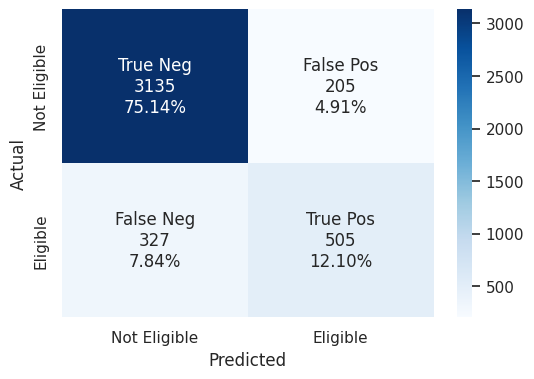

In [143]:

y_pred_train = lg.predict(x_train)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1431
           1       0.75      0.59      0.66       357

    accuracy                           0.88      1788
   macro avg       0.82      0.77      0.79      1788
weighted avg       0.87      0.88      0.87      1788



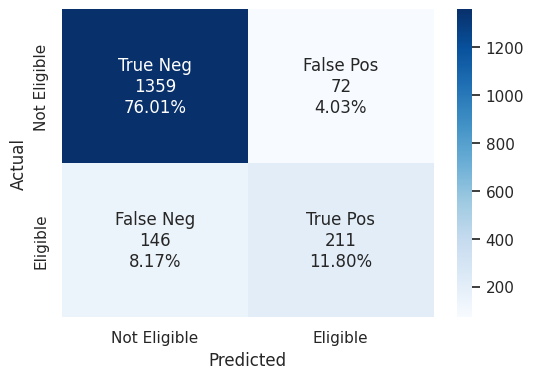

In [144]:
y_pred_test = lg.predict(x_test)

metrics_score(y_test, y_pred_test)

In [145]:
lg_test = model_performance_classification(lg,x_test,y_test)
lg_test

,Precision,Recall,Accuracy
0,0.824287,0.770361,0.878076


In [146]:
cols = X_scaled.columns

coef_lg = lg.coef_

pd.DataFrame(coef_lg,columns = cols).T.sort_values(by = 0, ascending = False)

,0
DEBTINC_missing_values_flag,1.157788
VALUE_missing_values_flag,0.735727
DEBTINC,0.686459
CLNO_missing_values_flag,0.326149
CLAGE_missing_values_flag,0.250206
NINQ,0.204533
MORTDUE_missing_values_flag,0.159940
REASON_HomeImp,0.114274
JOB_Sales,0.108807
VALUE,0.099661


Insights:

Features which positively affect on the defaulted rate are:

DEBTINC
NINQ
Features which negatively affect on the defaulted rate are:

MORTDUE
CLAGE The coefficients of the logistic regression model give us the log of odds, which is hard to interpret in the real world. We can convert the log of odds into odds by taking its exponential

In [147]:
odds = np.exp(lg.coef_[0]) # Finding the odds

pd.DataFrame(odds, x_train.columns, columns = ['odds']).sort_values(by = 'odds', ascending = False)

,odds
DEBTINC_missing_values_flag,3.182886
VALUE_missing_values_flag,2.086999
DEBTINC,1.986668
CLNO_missing_values_flag,1.385622
CLAGE_missing_values_flag,1.284290
NINQ,1.226953
MORTDUE_missing_values_flag,1.173441
REASON_HomeImp,1.121059
JOB_Sales,1.114947
VALUE,1.104796


The odds of defaulting for a client with high debt/income ratio is 50% higher than one with low ratio.
The odds of defaulting for a client with many recent credit inquiries is ~34% higher than one with a small number.

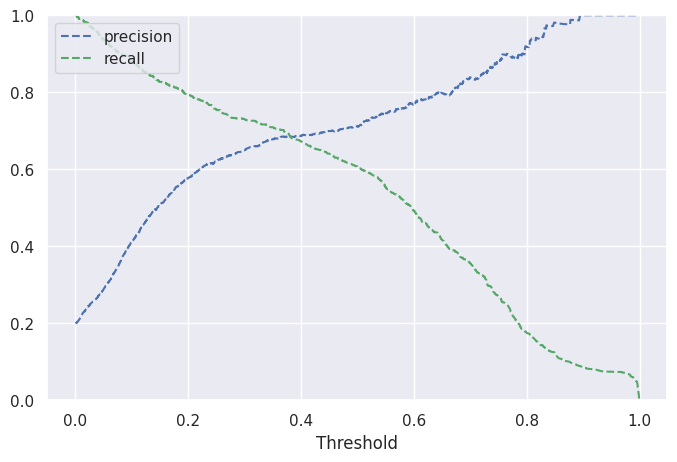

In [148]:
y_scores_lg = lg.predict_proba(x_train) # predict_proba gives the probability of each observation belonging to each class


precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:, 1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize = (8,5))

plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label = 'precision')

plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')

plt.xlabel('Threshold')

plt.legend(loc = 'upper left')

plt.ylim([0, 1])

plt.show()

Observation:

We can see that the precision and the recall are balanced for a threshold of about 0.28.

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3340
           1       0.64      0.73      0.68       832

    accuracy                           0.86      4172
   macro avg       0.78      0.81      0.80      4172
weighted avg       0.87      0.86      0.87      4172



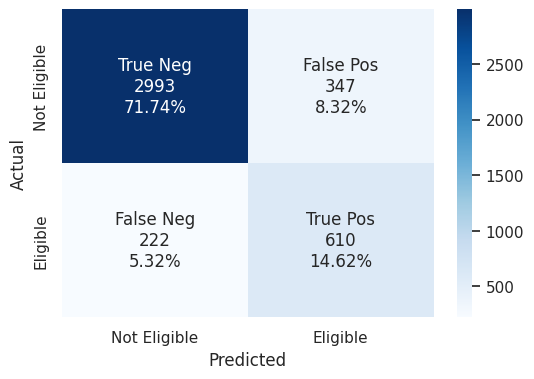

In [149]:
optimal_threshold1 = .28

y_pred_train = lg.predict_proba(x_train)

metrics_score(y_train, y_pred_train[:, 1] > optimal_threshold1)

Observations:

The model performance has improved. The recall has increased significantly for class 1 to 41%.

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1431
           1       0.67      0.72      0.69       357

    accuracy                           0.87      1788
   macro avg       0.80      0.82      0.81      1788
weighted avg       0.88      0.87      0.87      1788



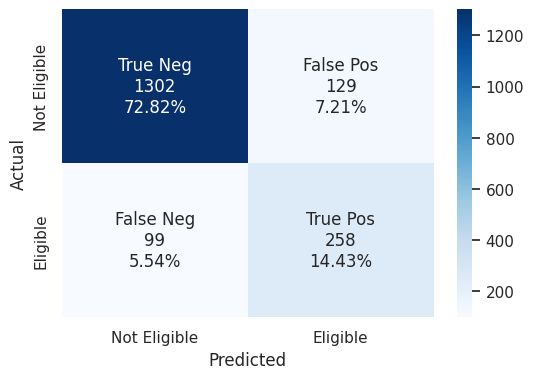

In [150]:
optimal_threshold1 = .28

y_pred_test = lg.predict_proba(x_test)

metrics_score(y_test, y_pred_test[:, 1] > optimal_threshold1)

Observations:

The model is giving a similar performance on the test and the train datasets, i.e., the model is giving a generalized performance.
The recall of the test data has increased to 41% while at the same time, the precision has decreased slightly, which is to be expected while adjusting the threshold.
Nevertheless, Recall is still low.

In [151]:
data = df.copy()

In [152]:
# Separating the target variable and other variables
Y = data.BAD
X = data.drop(columns = ['BAD'])
to_get_dummies_for = ['REASON', 'JOB']

# Creating dummy variables
X = pd.get_dummies(data = X, columns = to_get_dummies_for, drop_first = True)

In [153]:
X


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,...,0,0,0,1,True,False,True,False,False,False
1,1300,70053.0,68400.0,7.0,0.0,0.0,121.833333,0.0,14.0,34.818262,...,0,0,0,1,True,False,True,False,False,False
2,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,...,0,0,0,1,True,False,True,False,False,False
3,1500,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,...,1,1,1,1,False,False,True,False,False,False
4,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,...,0,0,0,1,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,41600,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,...,0,0,0,0,False,False,True,False,False,False
5956,41600,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,...,0,0,0,0,False,False,True,False,False,False
5957,41600,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,...,0,0,0,0,False,False,True,False,False,False
5958,41600,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,...,0,0,0,0,False,False,True,False,False,False


In [154]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [155]:
#Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8}
dt = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

In [156]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



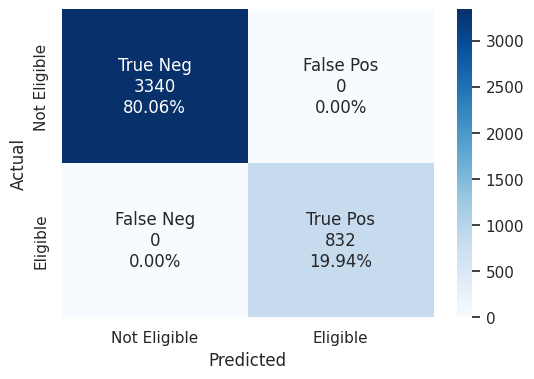

In [157]:
y_train_pred_dt = dt.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1431
           1       0.66      0.59      0.62       357

    accuracy                           0.86      1788
   macro avg       0.78      0.76      0.77      1788
weighted avg       0.85      0.86      0.85      1788



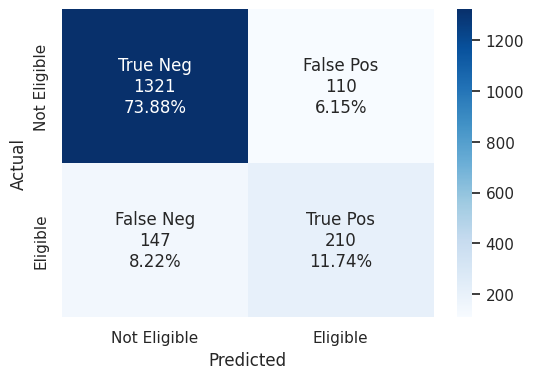

In [158]:
y_test_pred_dt = dt.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [159]:
dtree = model_performance_classification(dt,x_test,y_test)
dtree

,Precision,Recall,Accuracy
0,0.778057,0.755683,0.856264


Observations:

The Decision Tree works not so well on the test data as the recall is 0.59 in comparison to 1.00 for the training dataset, i.e., the Decision Tree is overfitting the training data.
The precision on the test data suggests that there's a 34% chance that the model will predict that a client is going to default even though he/she would not (false positive), increasing the risk for the bank to loses income.
The recall in this model is greater than in logistical regression.

<Axes: xlabel='Importance', ylabel='None'>

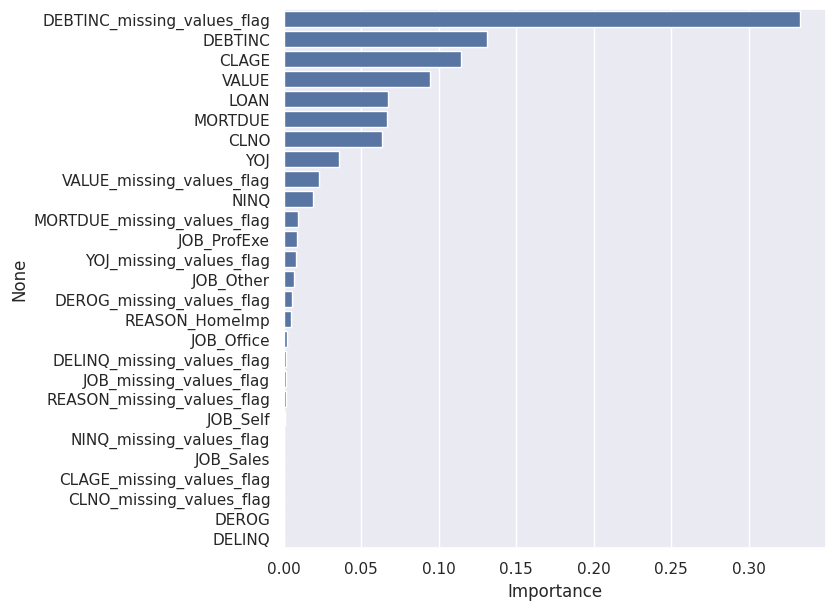

In [160]:
importances = dt.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (7, 7))
sns.barplot(x=importance_df.Importance, y=importance_df.index)

Observations:

According to the Decision Tree, DEBTINC_missing_values_flag is the most important feature, followed by DEBTINC. This signifies that applicants who are at risk of default a loan have high debt and relatively low income
The other important features CLNO, LOAN, CLAGE, VALUE, MORTDUE,CLNO.

In [161]:
# Choosing the type of classifier.
d_tree_tuned = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 10)


# Fitting the GridSearch on train dataset
gridCV = gridCV.fit(x_train, y_train)


# Setting the clf to the best combination of parameters
d_tree_tunedr = gridCV.best_estimator_


# Fitting the best algorithm to the data.
d_tree_tuned.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



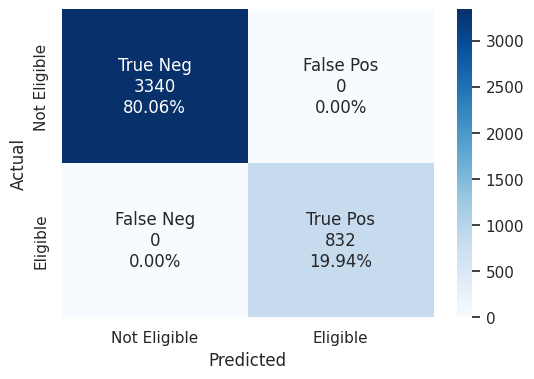

In [162]:
y_train_pred_dt = d_tree_tuned.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1431
           1       0.66      0.59      0.62       357

    accuracy                           0.86      1788
   macro avg       0.78      0.76      0.77      1788
weighted avg       0.85      0.86      0.85      1788



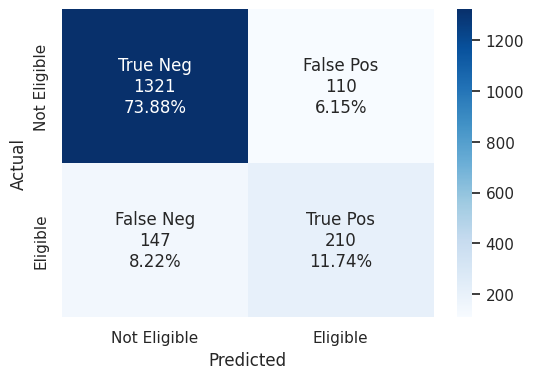

In [163]:
y_test_pred_dt = d_tree_tuned.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [164]:
dtree_tuned_test = model_performance_classification(d_tree_tuned,x_test,y_test)
dtree_tuned_test

,Precision,Recall,Accuracy
0,0.778057,0.755683,0.856264


Observations:

In comparison to the model with default values of hyperparameters, the performance on the training set has gone down significantly (1.00 to 0.74) This makes sense because we are trying to reduce overfitting.
The tuned model is performing well in comparison to the model with default values of hyperparameters: Recall increases from 0.61 to 0.74 in test data.
This model is not overfitting the training data and giving approximately the same result on the test and train datasets.
Precision has gone down significantly from .73 to .62 in comparison to the previous model which means the tuned model will give a high number of false positives, i.e., this model will predict the client is going to default even if he/she won't, and this will increases the risk of losing income.

<Axes: xlabel='Importance', ylabel='None'>

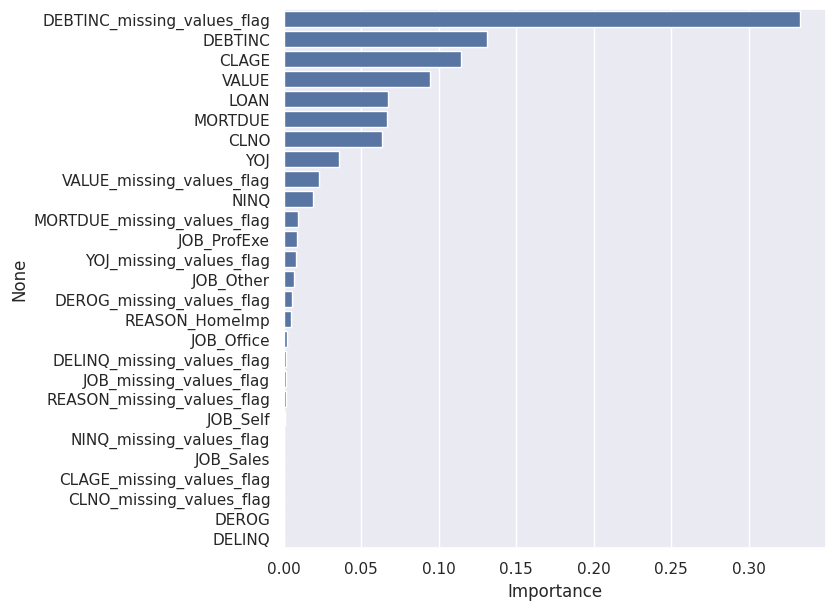

In [165]:
importances = d_tree_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (7, 7))

sns.barplot(x=importance_df.Importance,y= importance_df.index)

Observations:

According to this model too, DEBTINC_missing_value, DEBTINC, DELINQ, CLAGE, DEROG, CLNO, MORTDUEand YOG are the most important features that describe why a client is defaulting.
The tuned model is more generalized than the default model.

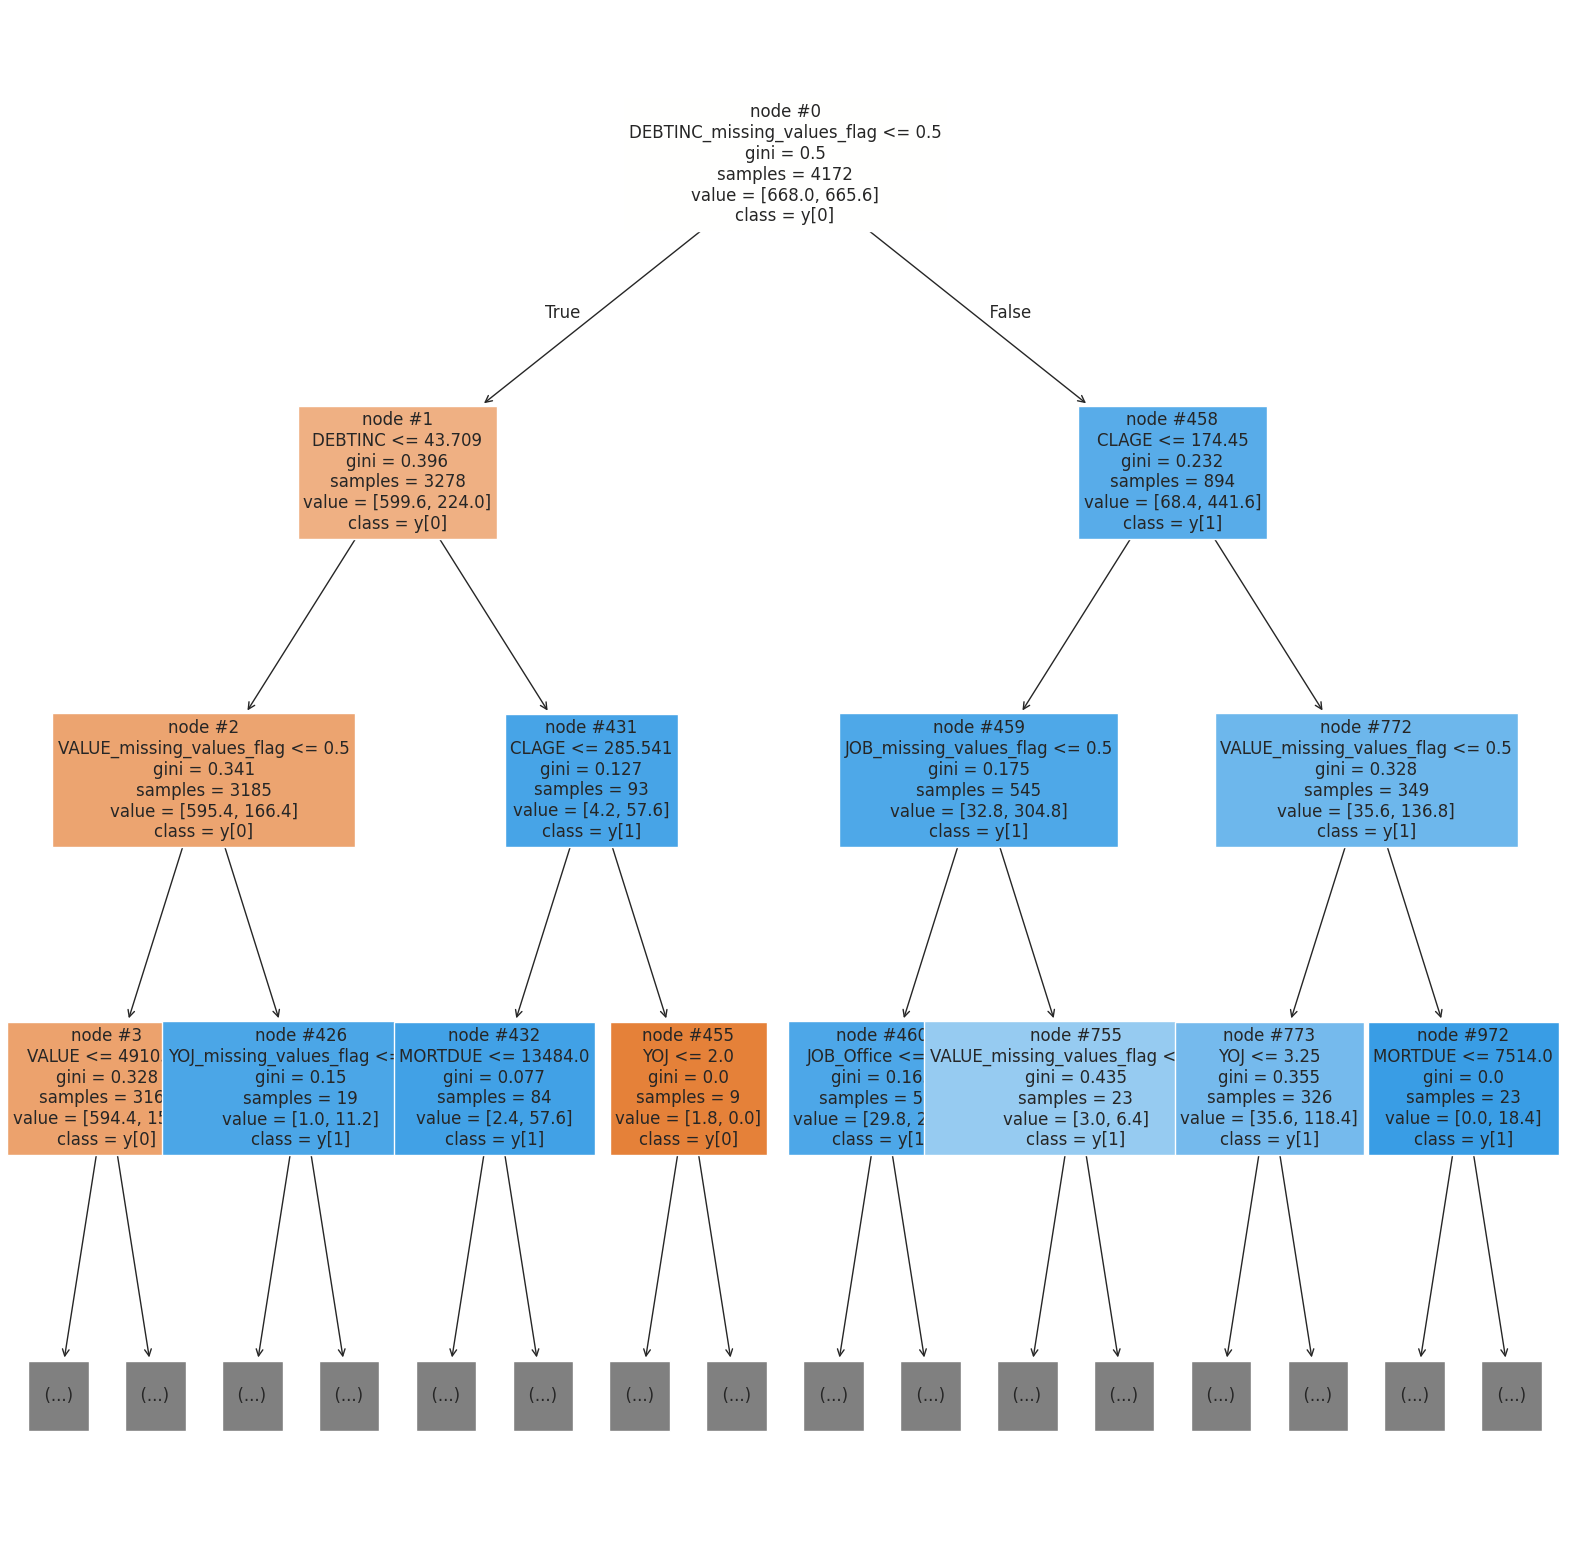

In [166]:
features = list(X.columns)

plt.figure(figsize = (20, 20))

tree.plot_tree(d_tree_tuned, max_depth = 3, feature_names = features, filled = True, fontsize = 12, node_ids = True, class_names = True)

plt.show()

Observations:

Blue leaves represent the defult loans, i.e., y[1] and the orange leaves represent the reapy loan, i.e., y[0].
The more the number of observations in a leaf, the darker its color gets.

In [167]:

rf_estimator = RandomForestClassifier(random_state = 1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



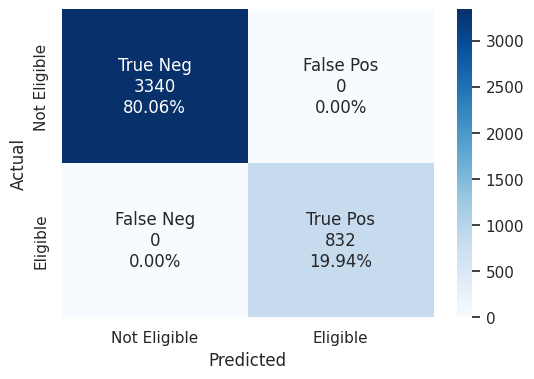

In [168]:
y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1431
           1       0.79      0.68      0.73       357

    accuracy                           0.90      1788
   macro avg       0.85      0.82      0.83      1788
weighted avg       0.90      0.90      0.90      1788



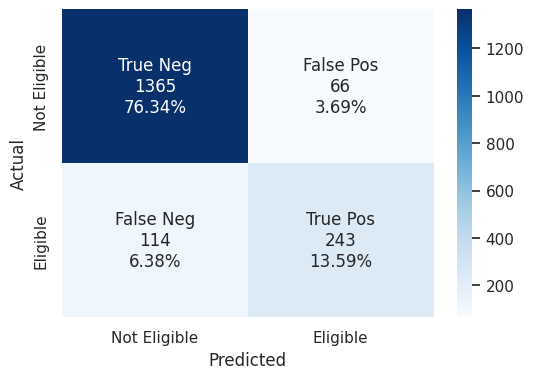

In [169]:
y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [170]:
rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
rf_estimator_test

,Precision,Recall,Accuracy
0,0.854664,0.817275,0.899329


Observations:

The Random Forest is giving a 100% score for all metrics on the training dataset.
The Random Forest classifier seems to be overfitting the training data. The recall on the training data is 1, while the recall on the test data is only 68% for class 1.
Precision is good for the test data- 79%

In [171]:
rf_estimator_balanced = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Fitting Random Forest model
rf_estimator_balanced.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



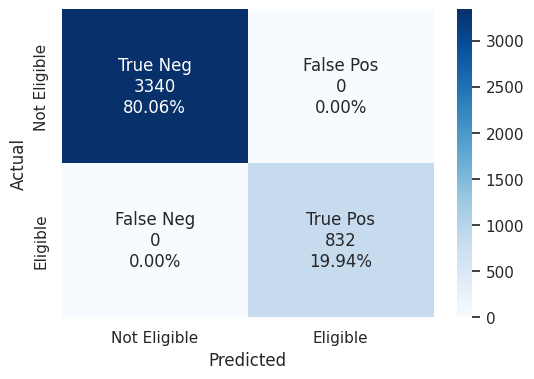

In [172]:
y_pred_train_rf = rf_estimator_balanced.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1431
           1       0.78      0.64      0.71       357

    accuracy                           0.89      1788
   macro avg       0.85      0.80      0.82      1788
weighted avg       0.89      0.89      0.89      1788



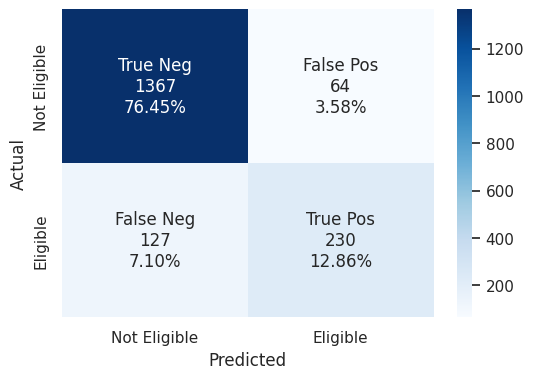

In [173]:
y_pred_test_rf = rf_estimator_balanced.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [174]:
rf_estimator_balanced_test = model_performance_classification(rf_estimator_balanced,x_test,y_test)
rf_estimator_balanced_test

,Precision,Recall,Accuracy
0,0.848653,0.799767,0.893177


Observations:

The balanced random forest did not improve the model performance and also giving a 100% score for all metrics on the training dataset.
It is is also overfitted the training data.
The recall on the training data is 1, while the recall on the test data is only 64% for class 1 compared to 68% in the baseline model
Precision is good for the test data- 78%

In [175]:
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 110, 120],
    "max_depth": [5, 6, 7],
    "max_features": [0.8, 0.9, 1]
             }

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [176]:
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=0.9,
                       random_state=7)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3340
           1       0.77      0.68      0.72       832

    accuracy                           0.90      4172
   macro avg       0.85      0.81      0.83      4172
weighted avg       0.89      0.90      0.89      4172



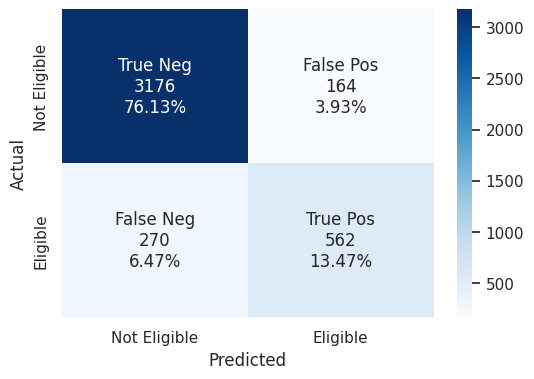

In [177]:
y_pred_train_rf = rf_estimator_tuned.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1431
           1       0.75      0.61      0.67       357

    accuracy                           0.88      1788
   macro avg       0.83      0.78      0.80      1788
weighted avg       0.88      0.88      0.88      1788



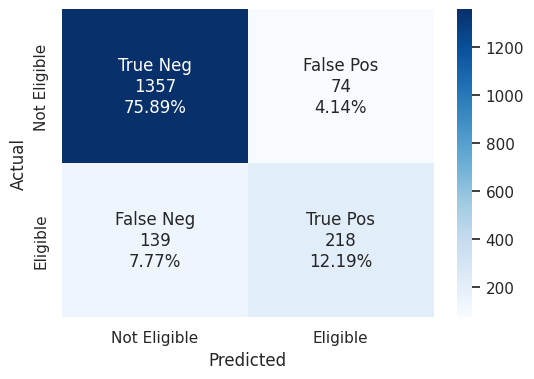

In [178]:
y_pred_test_rf = rf_estimator_tuned.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [179]:
rf_estimator_tuned_test = model_performance_classification(rf_estimator_tuned,x_test,y_test)
rf_estimator_tuned_test

,Precision,Recall,Accuracy
0,0.82683,0.779466,0.880872


Observation:

The tuned random forest improves the model performance and is not giving a 100% score for all metrics on the training dataset- there is less overfitting of the training data.
The recall on the training data is 68%, while the recall on the test data is only 61% for class 1 compared to 68% in the baseline model and 64% for the balanced random forest model.
Precision for the test set is 75%, it has decreased compared to the baseline model and balanced model.

<Axes: xlabel='Importance', ylabel='None'>

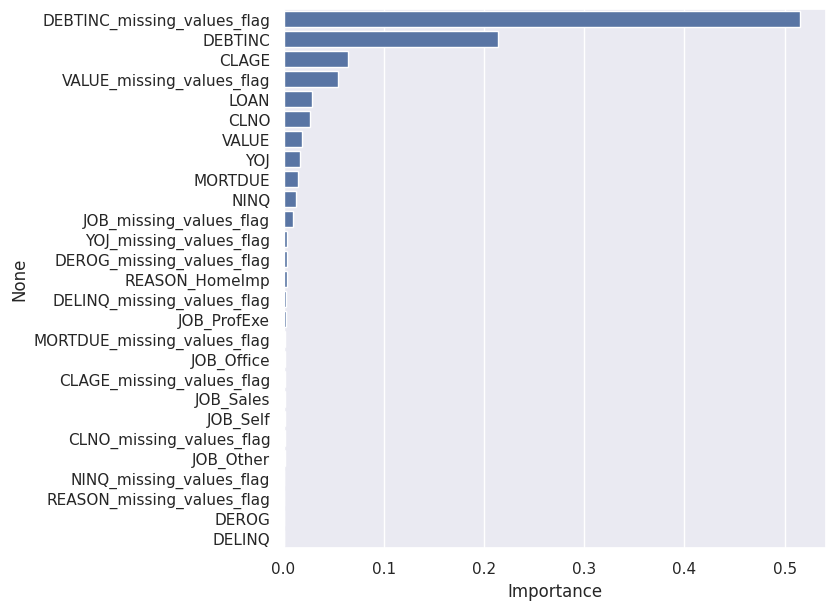

In [180]:
importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (7, 7))

sns.barplot(x=importance_df.Importance, y=importance_df.index)

In [181]:
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



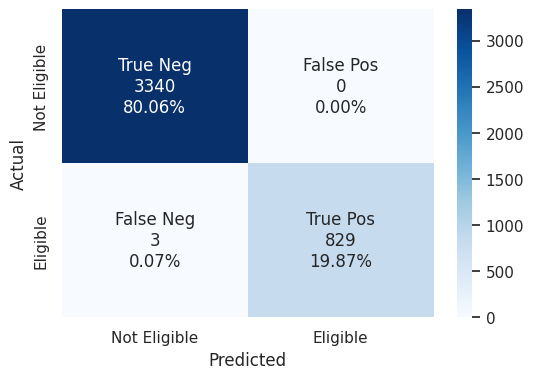

In [182]:
y_pred_train_xgb = xgb.predict(x_train)

metrics_score(y_train, y_pred_train_xgb)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.83      0.66      0.73       357

    accuracy                           0.90      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.90      0.90      1788



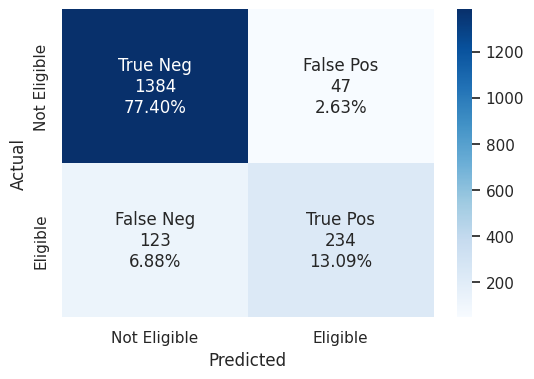

In [183]:
y_pred_test_xgb = xgb.predict(x_test)

metrics_score(y_test, y_pred_test_xgb)

In [184]:
xgb_perf_test = model_performance_classification(xgb,x_test,y_test)

xgb_perf_test

,Precision,Recall,Accuracy
0,0.875561,0.811309,0.904922


Observation:

The recall on the training data is 99%, while the recall on the test data is only 66% for class 1.
Precision for the test set is 87%.
It has highest recall, precision and accuracy compared to other models.

Comparing Model Performances

In [185]:
def get_accuracy_score(model,flag=True,X_train=x_train,X_test=x_test):
    '''
    model : classifier to predict values of X

    '''
    c = [] # defining an empty list to store train and test results
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    c.append(train_acc) # adding train accuracy to list
    c.append(test_acc) # adding test accuracy to list

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))

    return c # returning the list with train and test scores

In [188]:
models = [xgb,rf_estimator_tuned, rf_estimator_balanced, rf_estimator, d_tree_tuned, dt]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy,recall and precision scores
for model in models:

     # precision score
    l = get_precision_score(model,False)
    precision_train.append(l[0])
    precision_test.append(l[1])

    # accuracy score
    j = get_accuracy_score(model,False)
    acc_train.append(j[0])
    acc_test.append(j[1])

    # recall score
    k = get_recall_score(model,False)
    recall_train.append(k[0])
    recall_test.append(k[1])

In [189]:
comparison_frame = pd.DataFrame({'Model':['XGBoost classifier','Tuned Random Forest', 'Balanced Random Forest','Random Forest', 'Tuned Decision Tree', 'Decision Tree'],
                                          'Train_Accuracy': acc_train,
                                          'Test_Accuracy': acc_test,
                                          'Train_Recall': recall_train,
                                          'Test_Recall': recall_test,
                                          'Train_Precision': precision_train,
                                          'Test_Precision': precision_test})
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,XGBoost classifier,0.999281,0.904922,0.998197,0.811309,0.999551,0.875561
1,Tuned Random Forest,0.895973,0.880872,0.813189,0.779466,0.847876,0.826830
2,Balanced Random Forest,1.000000,0.893177,1.000000,0.799767,1.000000,0.848653
3,Random Forest,1.000000,0.899329,1.000000,0.817275,1.000000,0.854664
4,Tuned Decision Tree,1.000000,0.856264,1.000000,0.755683,1.000000,0.778057
5,Decision Tree,1.000000,0.856264,1.000000,0.755683,1.000000,0.778057


In [190]:
models_test_comp_df = pd.concat(

    [
    lg_test.T, dtree.T, dtree_tuned_test.T,rf_estimator_test.T,
    rf_estimator_balanced_test.T, rf_estimator_tuned_test.T, xgb_perf_test.T
    ],

    axis = 1,
)

models_test_comp_df.columns = [
    "Logistic regresstion model",
    "Decision Tree classifier",
    "Tuned Decision Tree classifier",
    "Random Forest classifier",
    "Balanced Random Forest classifier",
    "Tuned Random Forest classifier",
    "XGBoost classifier"
    ]

In [191]:
print("Test performance comparison:")
models_test_comp_df.T

Test performance comparison:


,Precision,Recall,Accuracy
Logistic regresstion model,0.824287,0.770361,0.878076
Decision Tree classifier,0.778057,0.755683,0.856264
Tuned Decision Tree classifier,0.778057,0.755683,0.856264
Random Forest classifier,0.854664,0.817275,0.899329
Balanced Random Forest classifier,0.848653,0.799767,0.893177
Tuned Random Forest classifier,0.826830,0.779466,0.880872
XGBoost classifier,0.875561,0.811309,0.904922


Refined insights:

Models with the higher test accuracy are the XGBoost Classifier ~.91.
All models overfit the training data with the exception of the Tuned Random Forest and XGBoost Classifier.
The highest recall (.82) belongs Random Forest and XGBoost Classifier. Higher than decision tree model.
Precision in XGBoost Classifier models are high (~.88). Is also higher than Decision Tree models and Random Forest model.

In [192]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_train)


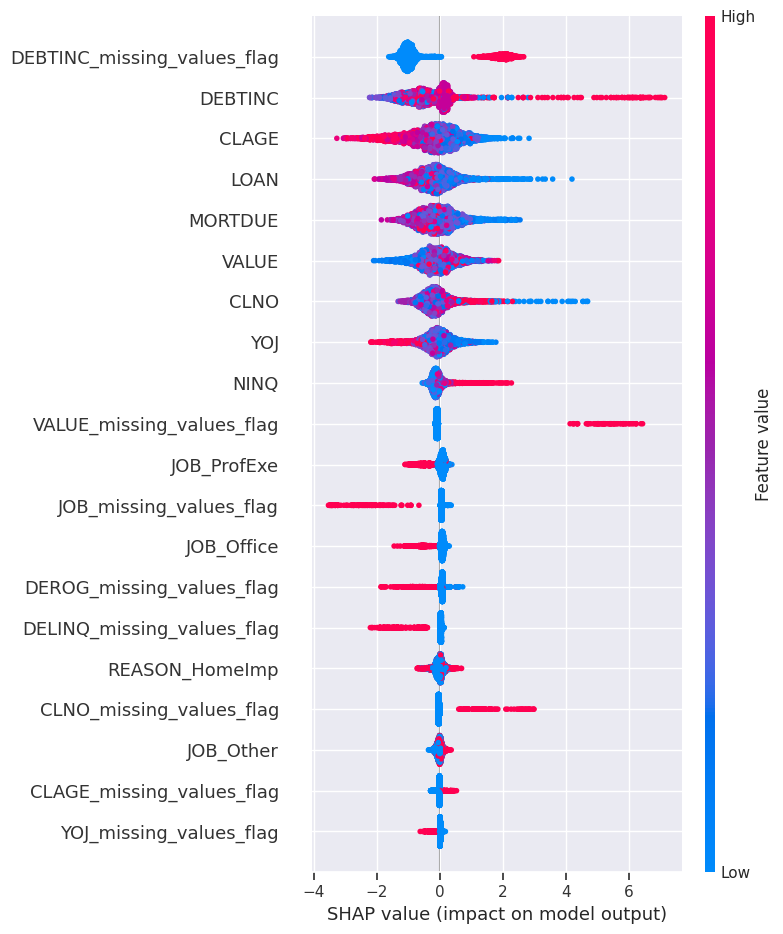

In [193]:
shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns)

Observations:

High DEBTINC values are on the right side primarily because they contribute positively to identify defaulter.
So, the prominent feature that is the most impactful in the change to default on a loan is the debt-to-income ratio.
